In [38]:
# %pip install catboost

In [39]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector

from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error, r2_score, make_scorer


In [40]:
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/Datasets/memora-games/'
df = pd.read_csv(file_path + "gw_session_data.csv")

gw_data = df.copy()
gw_data = pd.DataFrame(gw_data)

#Analysis
gw_data.describe().T

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,count,mean,std,min,25%,50%,75%,max
age,1352.0,67.944527,10.399099,50.0,59.000000,68.000000,77.000000,85.0
totalLevel,1352.0,10.000000,0.000000,10.0,10.000000,10.000000,10.000000,10.0
averageAttempts,1352.0,3.044379,1.276485,1.0,2.000000,3.000000,4.000000,5.0
averageLevelErrors,1352.0,0.769970,0.730767,0.0,0.000000,1.000000,1.000000,4.0
averageAccuracy,1352.0,78.934746,10.213020,50.0,71.817965,79.471055,86.441328,100.0
averageResponseTime,1352.0,8.611908,2.608348,0.6,6.800000,8.700000,10.200000,19.0
mmseScore,1352.0,23.012574,4.041310,10.0,20.000000,23.000000,26.000000,30.0


In [41]:
gw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1352 entries, 0 to 1351
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ssid                 1352 non-null   object 
 1   sessionDate          1352 non-null   object 
 2   age                  1352 non-null   int64  
 3   educationLevel       1352 non-null   object 
 4   totalLevel           1352 non-null   int64  
 5   averageAttempts      1352 non-null   int64  
 6   averageLevelErrors   1352 non-null   int64  
 7   averageAccuracy      1352 non-null   float64
 8   averageResponseTime  1352 non-null   float64
 9   mmseScore            1352 non-null   int64  
dtypes: float64(2), int64(5), object(3)
memory usage: 105.8+ KB


In [42]:
gw_data.drop(columns=['ssid', 'sessionDate', "totalLevel"], inplace=True)
gw_data.head(1)

,age,educationLevel,averageAttempts,averageLevelErrors,averageAccuracy,averageResponseTime,mmseScore
0,54,secondary,5,1,72.353442,7.4,20


In [43]:
categorical_columns= gw_data.select_dtypes(include=['object']).columns
categorical_columns

Index(['educationLevel'], dtype='object')

In [44]:
def add_engineered_features(df):
    df = df.copy()
    eps = 1e-5

    df['accuracyPerAttempt'] = df['averageAccuracy'] / (df['averageAttempts'] + eps)
    df['errorRate'] = df['averageLevelErrors'] / (df['averageAttempts'] + eps)
    df['speedScore'] = 1 / (df['averageResponseTime'] + eps)
    df['normalizedAccuracy'] = df['averageAccuracy'] / (df['age'] + eps)

    return df

gw_data = add_engineered_features(gw_data)
data = gw_data.copy()

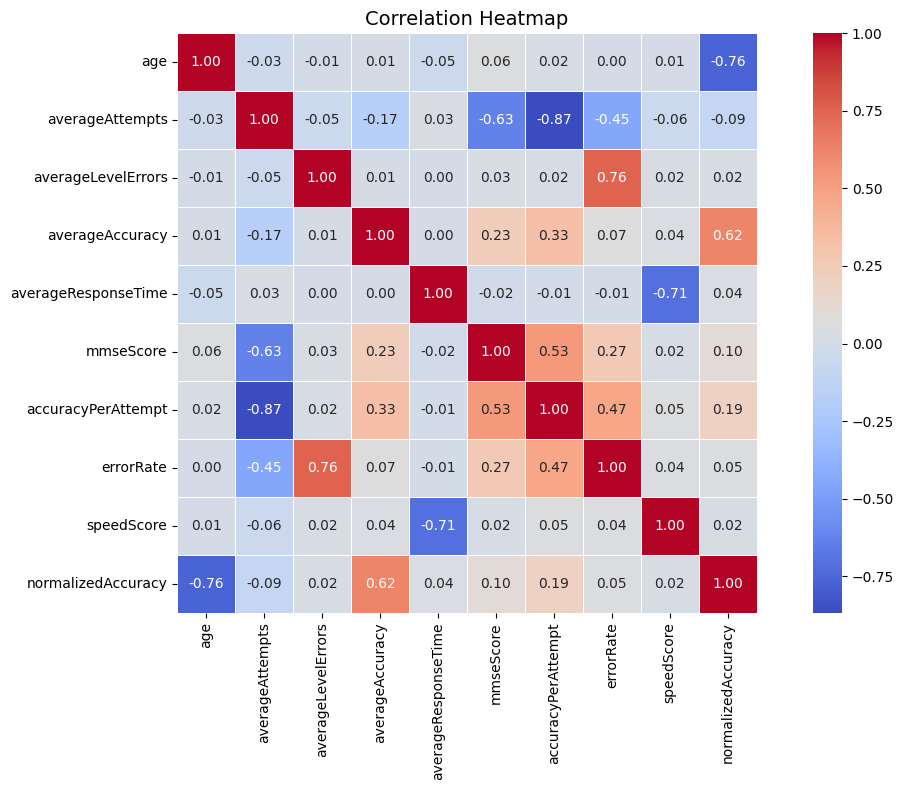

In [45]:
# Plotting correlation heatmap
plt.figure(figsize=(12, 8))  # Increase figure size

cor_matrix = data.corr(numeric_only=True)  # optional: ensure only numeric columns are used
sb.heatmap(
    cor_matrix,
    annot=True,
    fmt=".2f",          # Format the numbers to 2 decimal places
    cmap="coolwarm",    # Use a clearer color palette
    cbar=True,
    square=True,        # Make cells square
    linewidths=0.5,     # Add lines between boxes
    annot_kws={"size": 10}  # Font size of annotations
)

plt.xticks(rotation=90)  # Rotate x-axis labels
plt.yticks(rotation=0)   # Keep y-axis labels horizontal
plt.title("Correlation Heatmap", fontsize=14)
plt.tight_layout()
plt.show()

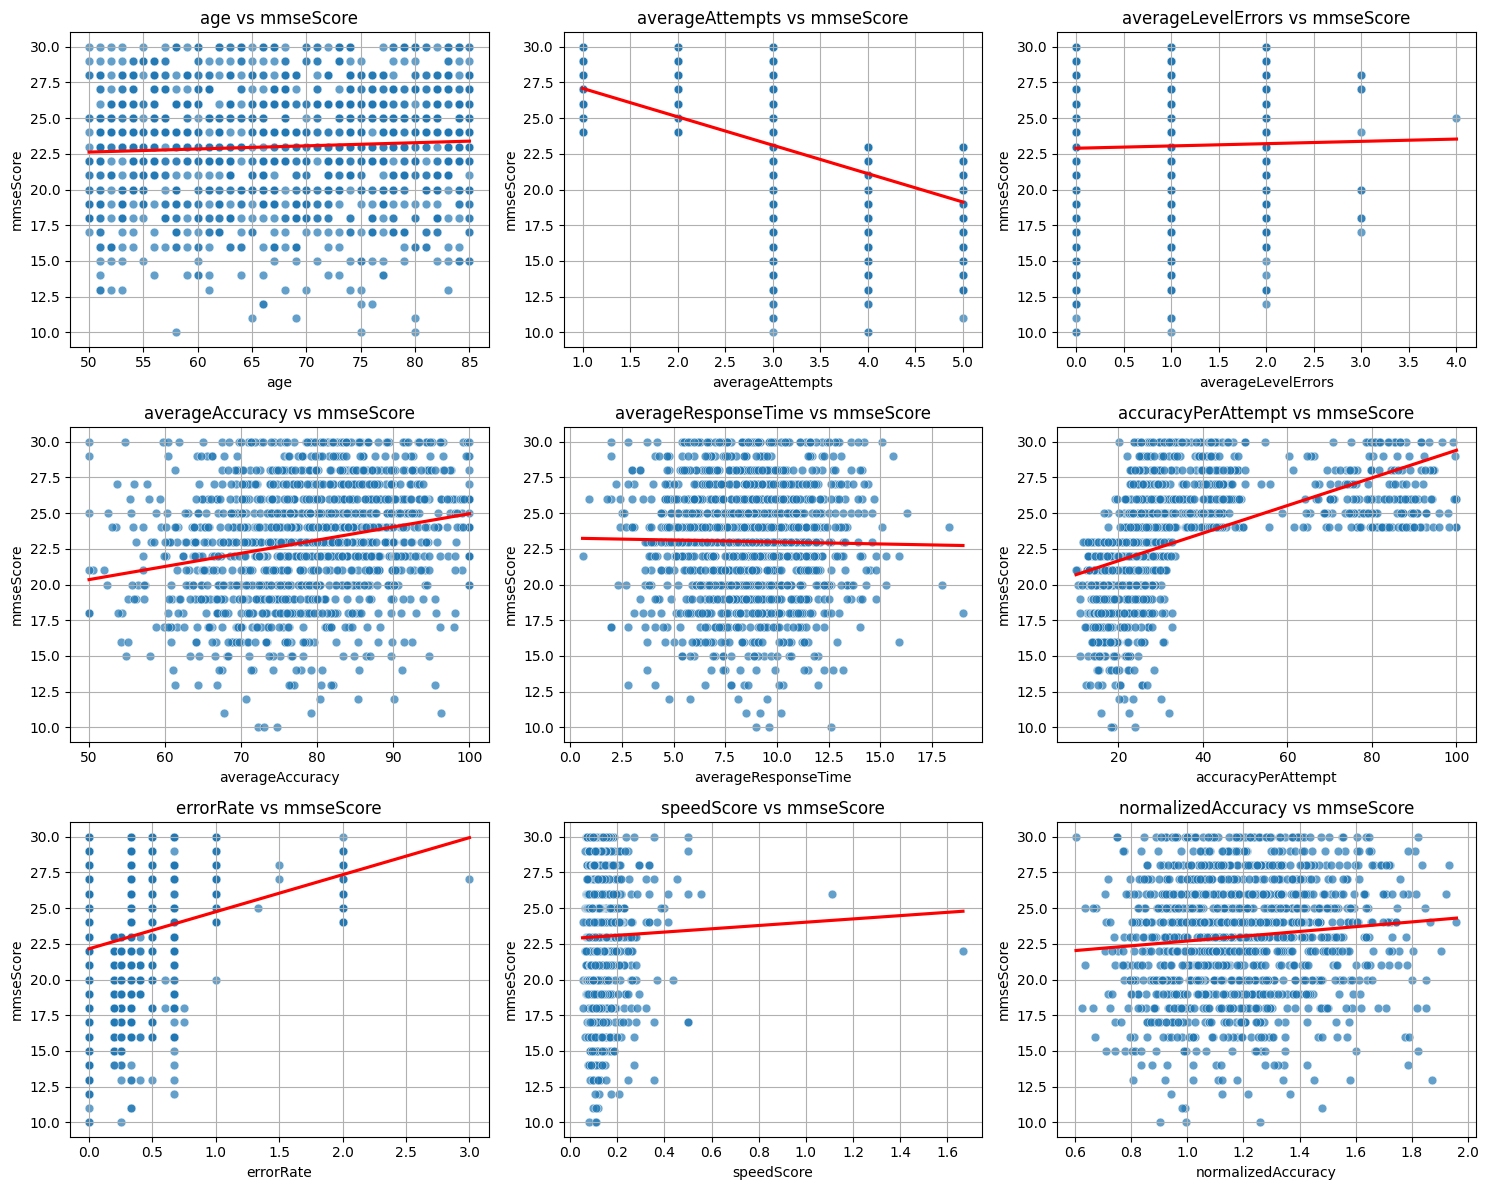

In [46]:
target   = "mmseScore"
features = data.drop(columns=[target, "educationLevel"]).columns.to_list()

n_cols   = 3                                # plots per row
n_rows   = -(-len(features) // n_cols)      # ceiling‑divide
figsize  = (5 * n_cols, 4 * n_rows)         # stretch as you like

fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
axes = axes.flatten()                       # turn to 1‑D array

for i, feat in enumerate(features):
    ax = axes[i]
    sb.scatterplot(data=data, x=feat, y=target, ax=ax, alpha=0.7, s=40)
    sb.regplot(data=data, x=feat, y=target, ax=ax, scatter=False,
                color="red", ci=None)       # optional trend‑line
    ax.set_title(f"{feat} vs {target}")
    ax.grid(True)

# Hide any unused empty sub‑plots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [47]:
features = gw_data.drop(columns=["mmseScore"]).columns.to_list()
target = "mmseScore"

X = data.drop(columns=[target], axis=1)
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("features: ", features, "\n\ntarget: ", target)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

features:  ['age', 'educationLevel', 'averageAttempts', 'averageLevelErrors', 'averageAccuracy', 'averageResponseTime', 'accuracyPerAttempt', 'errorRate', 'speedScore', 'normalizedAccuracy'] 

target:  mmseScore


((946, 10), (406, 10), (946,), (406,))

In [48]:
preprocessor = ColumnTransformer([
    ("ohe", OneHotEncoder(handle_unknown='ignore'), categorical_columns),
    ("scaler", StandardScaler(), ['age', 'averageAttempts', 'averageLevelErrors', 'averageAccuracy', 'averageResponseTime', 'accuracyPerAttempt', 'errorRate', 'speedScore', 'normalizedAccuracy'] )
])

pipelines = {
    'linear': Pipeline([
        ('preprocess', preprocessor),
        ('regressor', LinearRegression())
    ]),
    'lasso': Pipeline([
        ('preprocess', preprocessor),
        ('regressor', Lasso(max_iter=10000))
    ]),
    'ridge': Pipeline([
        ('preprocess', preprocessor),
        ('regressor', Ridge())
    ]),
    'elasticnet': Pipeline([
        ('preprocess', preprocessor),
        ('regressor', ElasticNet(max_iter=10000))
    ]),
    'svm': Pipeline([
        ('preprocess', preprocessor),
        ('regressor', SVR())
    ]),
    'rf': Pipeline([
        ('preprocess', preprocessor),
        ('regressor', RandomForestRegressor())
    ]),
    'xgb': Pipeline([
        ('preprocess', preprocessor),
        ('regressor', XGBRegressor(objective="reg:squarederror", verbosity=0))
    ]),
    'cat': Pipeline([
        ('preprocess', preprocessor),
        ('regressor', CatBoostRegressor(verbose=0))
    ]),
}

param_grid = {
    'linear': {},  # no hyperparameters
    'lasso': {
        'regressor__alpha': [0.01, 0.1, 0.3, 0.2, 10]
    },
    'ridge': {
        'regressor__alpha': [0.01, 0.1, 0.3, 0.2, 10]
    },
    'elasticnet': {
        'regressor__alpha': [0.01, 0.1, 1],
        'regressor__l1_ratio': [0.2, 0.5, 0.8]
    },
    'svm': {
        'regressor__C': [0.01, 0.1, 0.3, 0.2, 10],
        'regressor__kernel': ['linear', 'rbf']
    },
    'rf': {
        'regressor__n_estimators': [50, 100, 150, 200],
        'regressor__max_depth': [None, 10, 13, 15]
    },
    'xgb': {
        'regressor__n_estimators': [50, 100, 150, 200],
        'regressor__max_depth': [3, 6, 9]
    },
    'cat': {
        'regressor__depth': [4, 6],
        'regressor__learning_rate': [0.01, 0.02, 0.04, 0.1]
    }
}

In [49]:
best_models = {}

for name in pipelines:
    print(f"\n Tuning {name.upper()}...")
    search = GridSearchCV(
        pipelines[name],
        param_grid[name],
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    search.fit(X_train, y_train)
    best_models[name] = search.best_estimator_
    print(f"Best parameters for {name}: {search.best_params_}")

    # Evaluate on test set
    y_pred = search.predict(X_test)
    print(f"{name.upper()} Test MSE: {mean_squared_error(y_test, y_pred):.4f}, R²: {r2_score(y_test, y_pred):.4f}")

    # Cross-validation on training set
    print(f"{name.upper()} Cross-Validation on Training Set:")
    cv_results = cross_validate(
        search.best_estimator_,
        X_train,
        y_train,
        scoring=('neg_mean_squared_error', 'r2'),
        cv=5,
        n_jobs=-1
    )
    residuals = y_test - y_pred
    bias = residuals.mean()
    print(f"Mean prediction bias: {bias:.4f}")
    print(f"→ CV MSE: {-np.mean(cv_results['test_neg_mean_squared_error']):.4f} ± {np.std(cv_results['test_neg_mean_squared_error']):.4f}")
    print(f"→ CV R² : {np.mean(cv_results['test_r2']):.4f} ± {np.std(cv_results['test_r2']):.4f}")
    print("-" * 70)



 Tuning LINEAR...
Best parameters for linear: {}
LINEAR Test MSE: 7.9257, R²: 0.4801
LINEAR Cross-Validation on Training Set:
Mean prediction bias: 0.2275
→ CV MSE: 9.0308 ± 1.0623
→ CV R² : 0.4594 ± 0.0400
----------------------------------------------------------------------

 Tuning LASSO...
Best parameters for lasso: {'regressor__alpha': 0.01}
LASSO Test MSE: 7.9685, R²: 0.4772
LASSO Cross-Validation on Training Set:
Mean prediction bias: 0.2276
→ CV MSE: 9.0074 ± 1.0448
→ CV R² : 0.4608 ± 0.0392
----------------------------------------------------------------------

 Tuning RIDGE...
Best parameters for ridge: {'regressor__alpha': 10}
RIDGE Test MSE: 7.9786, R²: 0.4766
RIDGE Cross-Validation on Training Set:
Mean prediction bias: 0.2267
→ CV MSE: 9.0242 ± 1.0623
→ CV R² : 0.4599 ± 0.0397
----------------------------------------------------------------------

 Tuning ELASTICNET...
Best parameters for elasticnet: {'regressor__alpha': 0.01, 'regressor__l1_ratio': 0.8}
ELASTICNET Test

In [56]:
cat_pipeline = best_models['cat']
cat_model = best_models['cat'].named_steps['regressor']
importances = cat_model.get_feature_importance()

# Get feature names after preprocessing
ohe_feature_names = best_models['cat'].named_steps['preprocess'].transformers_[0][1].get_feature_names_out()
numeric_feature_names = best_models['cat'].named_steps['preprocess'].transformers_[1][2]

all_feature_names = list(ohe_feature_names) + list(numeric_feature_names)

# Create DataFrame
cat_feat_imp = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(cat_feat_imp)


                         Feature  Importance
10            accuracyPerAttempt   28.162516
6                averageAttempts   26.413789
2   educationLevel_postsecondary   10.965656
1    educationLevel_postgraduate    5.430707
13            normalizedAccuracy    4.819949
5                            age    4.412573
8                averageAccuracy    4.237815
7             averageLevelErrors    2.784309
11                     errorRate    2.720932
12                    speedScore    2.638375
9            averageResponseTime    2.537570
4       educationLevel_secondary    2.446106
3         educationLevel_primary    2.162238
0            educationLevel_none    0.267464


In [57]:
import joblib
joblib.dump(cat_pipeline, 'gw_cat_best_with_pipeline.pkl')

['gw_cat_best_with_pipeline.pkl']

In [58]:
model = joblib.load("gw_cat_best_with_pipeline.pkl")
preprocessor = model.named_steps['preprocess']
print(preprocessor.get_feature_names_out())

['ohe__educationLevel_none' 'ohe__educationLevel_postgraduate'
 'ohe__educationLevel_postsecondary' 'ohe__educationLevel_primary'
 'ohe__educationLevel_secondary' 'scaler__age' 'scaler__averageAttempts'
 'scaler__averageLevelErrors' 'scaler__averageAccuracy'
 'scaler__averageResponseTime' 'scaler__accuracyPerAttempt'
 'scaler__errorRate' 'scaler__speedScore' 'scaler__normalizedAccuracy']
